In this project I'll try to develop a model for earthquake prediction 

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load dataset
data = pd.read_csv("database.csv")
data.columns

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Depth Error',
       'Depth Seismic Stations', 'Magnitude', 'Magnitude Type',
       'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap',
       'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID',
       'Source', 'Location Source', 'Magnitude Source', 'Status'],
      dtype='object')

let’s see the main characteristics of earthquake data and create an object of these characteristics, namely, date, time, latitude, longitude, depth, magnitude

In [3]:
data = data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8


Since the data is random, so I need to scale it based on the model inputs. Here, I convert the given date and time to Unix time which is in seconds and a number. This can be easily used as an entry for the network I'll be building

In [4]:
import datetime
import time

timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        # print('ValueError')
        timestamp.append('ValueError')
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values
final_data = data.drop(['Date', 'Time'], axis=1)
final_data = final_data[final_data.Timestamp != 'ValueError']
final_data.head()

,Latitude,Longitude,Depth,Magnitude,Timestamp
0,19.246,145.616,131.6,6.0,-157634142.0
1,1.863,127.352,80.0,5.8,-157469411.0
2,-20.579,-173.972,20.0,6.2,-157359242.0
3,-59.076,-23.557,15.0,5.8,-157097417.0
4,11.938,126.427,15.0,5.8,-157030030.0


visualize the data on a world map,
that shows a clear representation of where the earthquake frequency will be more likely

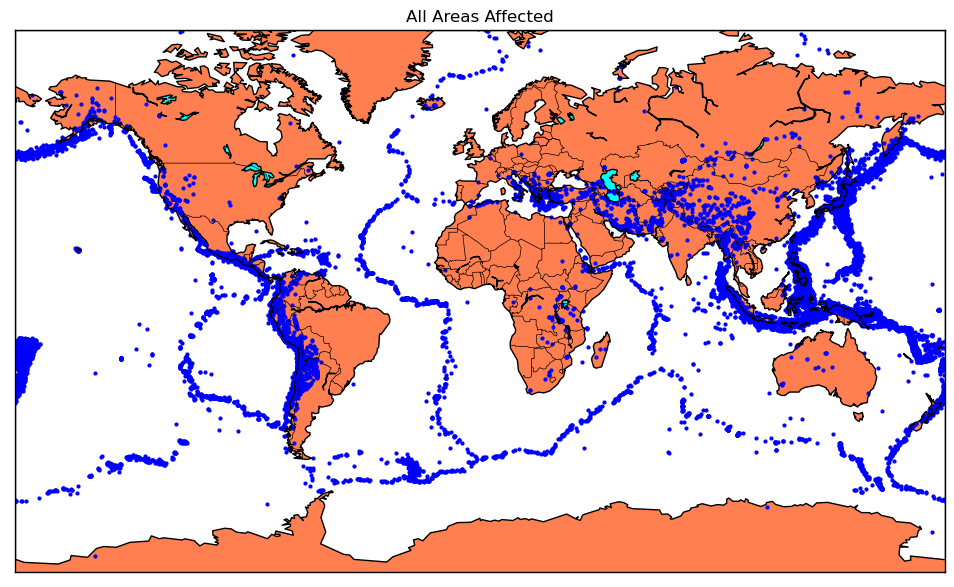

In [5]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()
#m = Basemap(width=12000000,height=9000000,projection='lcc',
            #resolution=None,lat_1=80.,lat_2=55,lat_0=80,lon_0=-107.)
x,y = m(longitudes,latitudes)

fig = plt.figure(figsize=(12,10))
plt.title("All Areas Affected")
m.plot(x, y, "o", markersize = 2, color = 'blue')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary()
m.drawcountries()
plt.show()

Now, to create the earthquake prediction model, we need to divide the data into Xs and Ys which respectively will be entered into the model as inputs to receive the output from the model.

Here the inputs are TImestamp, Latitude and Longitude and the outputs are Magnitude and Depth. I’m going to split the xs and ys into train and test with validation. The training set contains 80% and the test set contains 20%.

In [6]:
X = final_data[['Timestamp', 'Latitude', 'Longitude']]
y = final_data[['Magnitude', 'Depth']]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, X_test.shape)

(18727, 3) (4682, 3) (18727, 2) (4682, 3)


Now I will create a neural network to fit the data from the training set. This neural network will consist of three dense layers each with 16, 16, 2 nodes and reread. Relu and softmax will be used as activation functions:

In [7]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

Define the hyperparameters with two or more options to find the best fit---

In [8]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

# neurons = [16, 64, 128, 256]
neurons = [16]
# batch_size = [10, 20, 50, 100]
batch_size = [10]
epochs = [10]
# activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
activation = ['sigmoid', 'relu']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)


/var/folders/rm/lyn0g49d0yv5clbsr29pnjfm0000gn/T/ipykernel_16932/3896027448.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Now in order to need to find the best fit of the above model and get the mean test score and standard deviation of the best fit model---

In [14]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train.astype(np.float32), y_train.astype(np.float32))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.775971 using {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}
0.401011 (0.465541) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.775971 (0.388915) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}
0.412016 (0.480588) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.573675 (0.469020) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}


the best-fit parameters are used for the same model to calculate the score with the training data and the test data---

In [19]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(3,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', loss='squared_hinge', metrics=['accuracy'])
model.fit(X_train.astype(np.float32), y_train.astype(np.float32), batch_size=10, epochs=20, verbose=1, validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)))

[test_loss, test_acc] = model.evaluate(X_test.astype(np.float32), y_test.astype(np.float32))
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

Epoch 1/20
1873/1873 [==============================] - 5s 2ms/step - loss: 0.5038 - accuracy: 0.9182 - val_loss: 0.5038 - val_accuracy: 0.9242
Epoch 2/20
1873/1873 [==============================] - 4s 2ms/step - loss: 0.5038 - accuracy: 0.9182 - val_loss: 0.5038 - val_accuracy: 0.9242
Epoch 3/20
1873/1873 [==============================] - 4s 2ms/step - loss: 0.5038 - accuracy: 0.9182 - val_loss: 0.5038 - val_accuracy: 0.9242
Epoch 4/20
1873/1873 [==============================] - 4s 2ms/step - loss: 0.5038 - accuracy: 0.9182 - val_loss: 0.5038 - val_accuracy: 0.9242
Epoch 5/20
1873/1873 [==============================] - 4s 2ms/step - loss: 0.5038 - accuracy: 0.9182 - val_loss: 0.5038 - val_accuracy: 0.9242
Epoch 6/20
1873/1873 [==============================] - 5s 2ms/step - loss: 0.5038 - accuracy: 0.9182 - val_loss: 0.5038 - val_accuracy: 0.9242
Epoch 7/20
1873/1873 [==============================] - 4s 2ms/step - loss: 0.5038 - accuracy: 0.9182 - val_loss: 0.5038 - val_accuracy:

So, finally, it can be seen that the neural network model for earthquake prediction performs well.